In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm
import pandas as pd

sys.path.append('..')
from sim_biology import p, load_dataloader_and_pretrained_model, dataloader_to_nparrays
p.is_continuous = True
# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dreconstruct, plot_1dfilts, plot_wavefun

# load results

In [2]:
dirs = ["db5_saliency_warmstart_lamL1wave=0.1_seed=100"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/ex_biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.1).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

## load data and model

In [3]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p)
torch.manual_seed(p.seed)
data = iter(test_loader).next()[0].to(device)

# Plotting

Hyperparameter: lamL1wave=0.100000 lamL1attr=0.429190
Error: Recon=0.000403


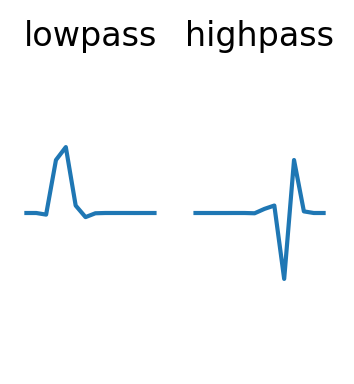

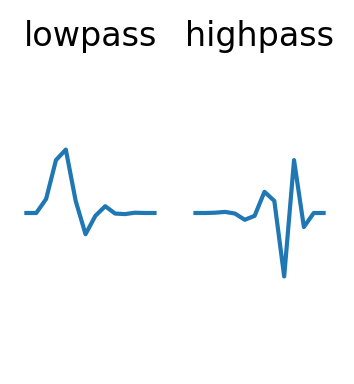

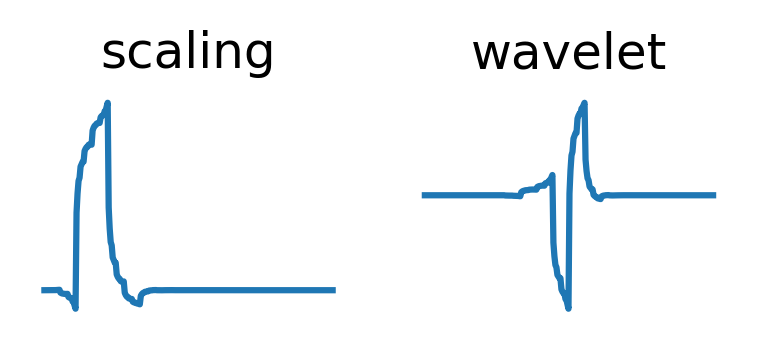

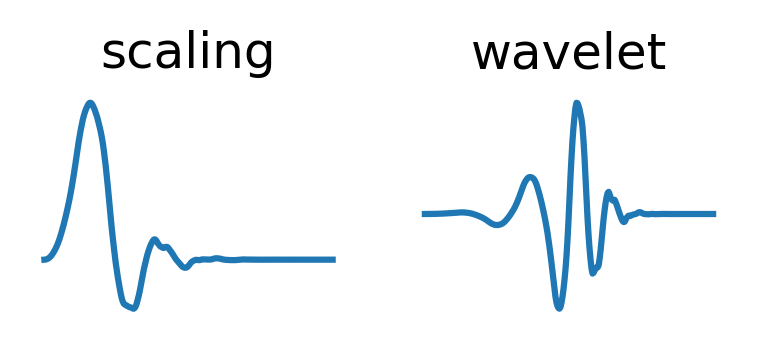

In [4]:
res = results[0]
mos = models[0]
lamL1attrs = np.array(res['lamL1attr'])
index = {}
for i in range(50):
    index[i] = np.argsort(lamL1attrs)[i]
rec_loss = np.array(res['rec_loss'])[np.argsort(lamL1attrs)]
L1saliency_loss = np.array(res['L1saliency_loss'])[np.argsort(lamL1attrs)]
L1inputxgrad_loss = np.array(res['L1inputxgrad_loss'])[np.argsort(lamL1attrs)]    

ix = 20
wt = mos[index[ix]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index[ix]], res['lamL1attr'][index[ix]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index[ix]]))

# original wavelet
wt_o = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
filt_o = get_1dfilts(wt_o)
phi_o, psi_o, x_o = get_wavefun(wt_o)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_1dfilts(filt_o, is_title=True, figsize=(2,2))

plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))
plot_wavefun((phi_o, psi_o, x_o), is_title=True, figsize=(3,1))

In [5]:
from sklearn.linear_model import LogisticRegression

wt = wt.to('cpu')

(X, y), (X_test, y_test) = dataloader_to_nparrays(wt, train_loader, test_loader)

(array([1168.,    2.,  105.,  522.,  610.,  323.,  140.,   43.,   14.,
           9.]),
 array([-1.4076557e+00, -9.3842763e-01, -4.6919957e-01,  2.8514862e-05,
         4.6925658e-01,  9.3848467e-01,  1.4077127e+00,  1.8769408e+00,
         2.3461690e+00,  2.8153970e+00,  3.2846251e+00], dtype=float32),
 <a list of 10 Patch objects>)

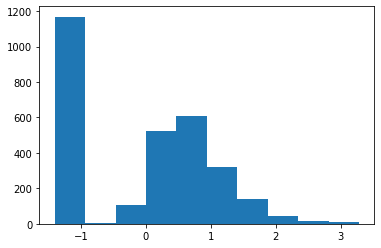

In [9]:
plt.hist(y)

In [ ]:
X.shape

In [ ]:
wt = wt.to('cpu')

(X, y), (X_test, y_test) = dataloader_to_nparrays(wt, train_loader, test_loader)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=1e6, tol=1e-6, warm_start=True, random_state=0)

Cs = np.arange(0.001, 1, 0.001)
errs = np.empty(len(Cs))
nnzs = np.empty(len(Cs))
for i, C in enumerate(Cs):
    print('\riteration {}/{}'.format(i, len(Cs)), end='')
    clf.set_params(C=C)
    clf.fit(X, y)
    preds = clf.predict(X_test)
    error = abs(preds - y_test).sum()/X_test.shape[0]
    errs[i] = error
    nnzs[i] = np.sum(clf.coef_ != 0)

In [ ]:
wt_o = wt_o.to('cpu')

(X, y), (X_test, y_test) = dataloader_to_nparrays(wt_o, train_loader, test_loader)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=1e6, tol=1e-6, warm_start=True, random_state=0)

Cs = np.arange(0.001, 1, 0.001)
errs_o = np.empty(len(Cs))
nnzs_o = np.empty(len(Cs))
for i, C in enumerate(Cs):
    print('\riteration {}/{}'.format(i, len(Cs)), end='')
    clf.set_params(C=C)
    clf.fit(X, y)
    preds = clf.predict(X_test)
    error = abs(preds - y_test).sum()/X_test.shape[0]
    errs_o[i] = error
    nnzs_o[i] = np.sum(clf.coef_ != 0)

In [ ]:
plt.hist(errs[nnzs < 10], density=True, bins=30)
plt.show()

In [ ]:
plt.hist(errs_o[nnzs_o < 10], density=True, bins=30)
plt.show()

In [ ]:
#### plot original and reconstruction images
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))
plot_1dreconstruct(data, recon)

In [ ]:
plt.plot(np.log(res['train_losses'][index[ix]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [ ]:
# validator 
validator = Validator(model, test_loader)

# original wavelet transform
rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(wt, target=0)
rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o = validator(wt_o, target=0)

print("\n\n \t Original filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f} \n \
        Adaptive filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f}"\
          .format(rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o, 
                  rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss))

In [ ]:
# phi, psi, x = get_wavefun(wt)
wt_o = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.1).to(device)
filt_o = get_1dfilts(wt_o)
phi, psi, x = get_wavefun(wt_o)

In [ ]:
plot_1dfilts(filt_o, is_title=True, figsize=(2,2))

In [ ]:
visualize.plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))